# Week 8 - Semantic Networks

intro...

# Note

Getting igraph to make plots was a lot of work, the steps I ended up with are:

+ install `cairocffi`, remove `pycairo` if present
+ install `igraph` version `0.7.1` from the github repo, **Do not** use the pypi version, there is a [known issue](https://github.com/igraph/python-igraph/issues/89)

For this notebook we will be using the following packages.

In [1]:
import nltk
import sklearn
import pandas
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn
import igraph as ig
import pickle

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph

In [2]:
g = ig.Graph()
g

We can add vertices, they are all numbered starting at 0 so this will add vertices `0`, `1` and `2`.

In [3]:
g.add_vertices(3)

Now we have 3 vertices

In [4]:
g.vcount()

3

Or if we want to get more information about the graph

In [5]:
print(g.summary())

IGRAPH U--- 3 0 -- 


We can give vertices names, or even give the graph a name.

In [6]:
g.vs['name'] = ['a', 'b', 'c'] #vs stands for VertexSeq(uence)

Now we can get vertices by name

In [7]:
g.vs.find('a')

igraph.Vertex(<igraph.Graph object at 0x10be86228>, 0, {'name': 'a'})

Still pretty boring though

Lets add a couple of edges, notice we can use names or ids

In [8]:
g.add_edges([(0,1), (1,2), ('a', 'c')])
print(g.summary())

IGRAPH UN-- 3 3 -- 
+ attr: name (v)


Notice the summary has changed

We can also give the edges properties, but instead of names we give weights

In [9]:
print("Before weighted", g.is_weighted())
g.es['a', 'b']['weight'] = 4
g.es['a', 'c']['weight'] = 10
print("After weighted", g.is_weighted())

Before weighted False
After weighted True


Let's visualize it

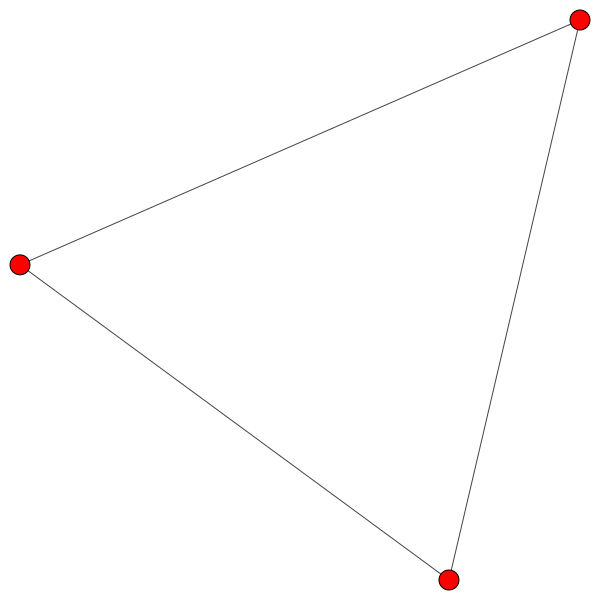

In [10]:
ig.plot(g)

Very exciting

There are a large number of things to do with the graph once we have created it, but we have to move on to using them now.

First lets load our data, the Grimmer corpus

In [11]:
senReleasesDF = pandas.read_csv('data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:5]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   
3  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy11.txt   
4  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy12.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy  
3           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy  
4           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming

In [12]:
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)

    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))

    return list(workingIter)

stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

For now we will not be dropping any stop words

In [13]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [normlizeTokens(s, stopwordLst = None, stemmer = snowball) for s in x])

senReleasesDF[:5]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   
3  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy11.txt   
4  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy12.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                                text targetSenator  \
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
3           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
4           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   

                                     tokenized_sents  \
0  [[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...   
1  [[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...   
2  [[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...   
3  [[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...   
4  [[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...   

                                    normalized_sents  
0  [[for, immedi, releas, for, immedi, releas, co...  
1  [[for, immedi, releas, for, immedi, releas, co...  
2  [[for, immedi, releas, for, immedi, releas, wa...  
3  [[for, immedi, releas, for, immedi, releas, wa...  
4  [[for, immedi, releas, for, immedi, releas, co...

Lets start by lookking at words co-occurring in same sentences

In [14]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        edges = list(zip(*np.where(coOcMat)))
        weights = coOcMat[np.where(coOcMat)]
        g = ig.Graph( n = len(wordLst),
            edges = edges,
            vertex_attrs = {'name' : wordLst, 'label' : wordLst},
            edge_attrs = {'weight' : weights}
                    )
        return g

Build a graph based on word cooccureence in the first 100 press releases.

In [15]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices

In [16]:
g.vcount()

4394

Total number of edeges

In [17]:
g.ecount()

4944446

The adjacency matrix

In [18]:
g.get_adjacency()[:10, :10]

Matrix([[1, 0, 0, 0, 2, 2, 0, 2, 0, 0], [0, 1, 2, 2, 2, 2, 0, 2, 0, 0], [0, 2, 1, 2, 2, 2, 0, 2, 0, 0], [0, 2, 2, 1, 2, 2, 0, 2, 0, 0], [2, 2, 2, 2, 1, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 1, 2, 2, 2, 0], [0, 0, 0, 0, 2, 2, 0, 0, 2, 0], [2, 2, 2, 2, 2, 2, 0, 1, 2, 0], [0, 0, 0, 0, 2, 2, 2, 2, 1, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0]])

We can save the graph and read it later.

In [19]:
g.write_gml('Obama_words.gml')

Or, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [20]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = normlizeTokens(tokenlist, stemmer = snowball)
    return normalized

In [21]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words='english', tokenizer = tokenize)
senVects = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [22]:
senVects.shape

(100, 4194)

We need to turn the matrix into a list as our input.

In [23]:
INP = senVects.todense().tolist()

In [24]:
g = ig.Graph.Incidence(INP, multiple=True)

We can check whether it is a bipartite network.

In [25]:
g.is_bipartite()

True

Give colors and shapes to documents and words.

In [26]:
g.vs['color']  = ['red']*senVects.shape[0] + ['blue']*senVects.shape[1]
g.vs['shape']  = ['square']*senVects.shape[0] + ['circle']*senVects.shape[1]

A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm. However, for a large graph, the algorithm is computational demanding. The commented code gives you a layout and save it as a pickle. Let's then load a layout.

In [27]:
#layout = g.layout_fruchterman_reingold()
#pickle.dump(layout, open( "layout.pkl", "wb" ) )
#layout = pickle.load(open('layout.pkl','rb'))

Then, let's plot the bipartite network.

In [28]:
#ig.plot(g, layout = None, vertex_size = 5)

A faster algorithm for large networks is the Large Graph Layout algorithm. If want even more faster computation, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

In [29]:
#layout = g.layout_lgl()

A two-mode network can be easily transformed into two one-mode network. 

In [30]:
gDoc, gWord = g.bipartite_projection()

Let's first take a look at the document-to-document network.

In [31]:
gDoc.summary()

'IGRAPH U-WT 100 4950 -- \n+ attr: color (v), shape (v), type (v), weight (e)'

Let's do a visualization. It is not surprising that almost every document is connected to every one else. We can use edge weight to distinguish attraction between the nodes.

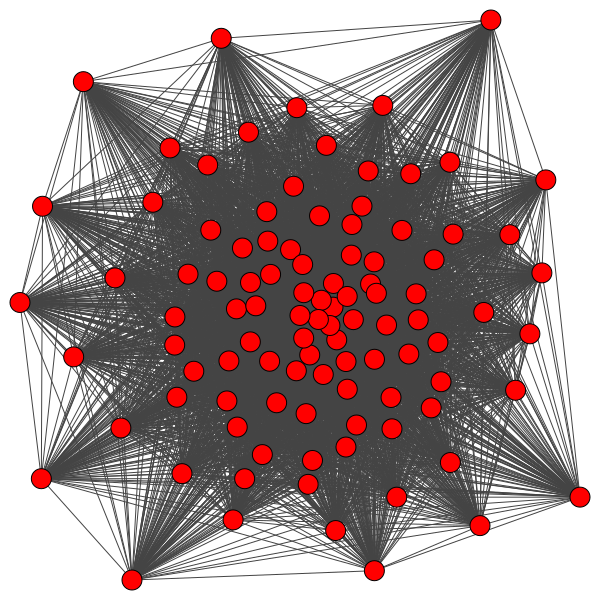

In [32]:
layout = gDoc.layout_fruchterman_reingold(weights = gDoc.es['weight'])
ig.plot(gDoc, layout = layout, vertex_shape = 'circle')

Another way to visualize the graph is to binarize the adjacency matrix with some cutoff values for edge weight. Let's use the medianw weight as our cutoff weight.

In [33]:
median = np.median(gDoc.es['weight'])
medEdges = gDoc.es.select(lambda x: x['weight'] > median)
g1_d = g.subgraph_edges(medEdges)

In [34]:
g1_d.summary()

'IGRAPH U--T 866 2469 -- \n+ attr: color (v), shape (v), type (v)'

In [35]:
layout = g1_d.layout_fruchterman_reingold(area = 10000000)
ig.plot(g1_d, layout = layout, vertex_shape = 'circle')

Let's look at the word-to-word network. Instead of working directly with `gWord`, let's start with matrix multiplication which gives us more freedom to define edge weight. First, let's reduce the number of words to a manageable size.

In [36]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words='english', tokenizer = tokenize, max_features = 200)
senVects = senVectorizer.fit_transform(senReleasesDF['text'][:100])
wordsLst = senVectorizer.get_feature_names()
senVects.shape

(100, 200)

Let's define the weight of an edge to the be number of coocurrences of two words divided by the square root of the product of their marginal frequencies.

In [37]:
A = senVects.todense() #Get the doc-word frequency matrix.
M = np.sum(A, axis = 0) #The marginal frequencies are simplies the column sums.
W = A.T.dot(A)/np.sqrt(M.T.dot(M)) #Get out weight matrix.
np.fill_diagonal(W,0) #Set the diagonal to zero.

In [38]:
G = ig.Graph.Weighted_Adjacency(W.tolist(), mode=ig.ADJ_UNDIRECTED)
G.vs['name'] = wordsLst #Names are what you reference
G.vs['label'] = wordsLst #Label are what is displayed

Visualization:

In [39]:
layout = G.layout_fruchterman_reingold()

In [40]:
ig.plot(G, layout = layout, vertex_size = 20, edge_width = 0.1)

Or input the weight matrix with some cutoff value. We will be using 9 for now as it is good for demonstrating, but you should pick 

In [41]:
cutoff = 9
G_b = G.subgraph_edges(G.es.select(lambda x: x['weight'] > cutoff))

In [42]:
layout = G_b.layout_fruchterman_reingold()

In [43]:
ig.plot(G_b, layout = None, vertex_size = 20, edge_width = 0.2)

Instead of visualizing there are some more informative stats.

Lets start with some measures of centrality

In [44]:
G_b.vs[np.argmax(G_b.betweenness())]

igraph.Vertex(<igraph.Graph object at 0x10be867c8>, 34, {'label': 'health', 'name': 'health'})

We can colour and size the nodes by the betweenness centrality

In [45]:
pal = ig.GradientPalette("red", "blue", G_b.vcount())
G_b.vs['color'] = [pal.get(int(v)) for v in np.argsort(G_b.betweenness())]
ig.plot(G_b, layout = layout, edge_width = 0.2)

Or look at degree centrality

In [46]:
G_b.vs[np.argmax(G_b.degree())]

igraph.Vertex(<igraph.Graph object at 0x10be867c8>, 34, {'label': 'health', 'color': (0.19999999999999996, 0.0, 0.8, 1.0), 'name': 'health'})

In [47]:
pal = ig.GradientPalette("red", "blue", max(G_b.degree()) + 1)
G_b.vs['color'] = [pal.get(v) for v in G_b.degree()]
ig.plot(G_b, layout = layout, edge_width = 0.2)

Or look at closeness centrality

In [48]:
G_b.vs[np.argmax(G_b.closeness())]

igraph.Vertex(<igraph.Graph object at 0x10be867c8>, 34, {'label': 'health', 'color': (0.0, 0.0, 1.0, 1.0), 'name': 'health'})

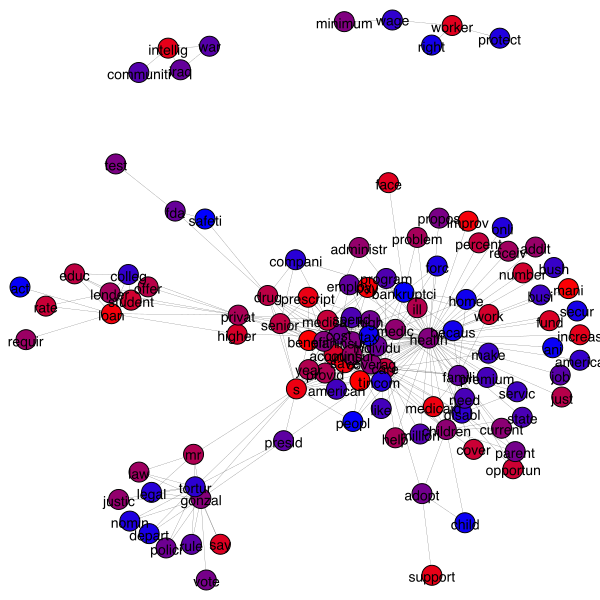

In [49]:
pal = ig.GradientPalette("red", "blue", G_b.vcount())
G_b.vs['color'] = [pal.get(int(v)) for v in np.argsort(G_b.closeness())]
ig.plot(G_b, layout = layout, edge_width = 0.2)

We can also look at global statistics

Like density

In [50]:
G_b.density()

0.06044226044226044

average degree

In [51]:
np.mean(G_b.degree())

6.6486486486486482

diameter

In [52]:
G_b.diameter()

6

Find cliques

In [53]:
G_b.largest_cliques()

[(34, 13, 19, 73, 44, 91, 104, 0, 43, 101, 21, 59),
 (34, 13, 19, 73, 44, 91, 104, 0, 43, 101, 21, 41)]

In [54]:
print(', '.join((G_b.vs[i]['name'] for i in G_b.largest_cliques()[0])))

health, care, cost, plan, insur, save, uninsur, account, individu, tax, coverag, medicar
